In [1]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.4 MB/s eta 0:00:00


In [2]:
# Importing Necessary Libraries

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

from torcheval.metrics.functional import binary_f1_score

import torch.nn.functional as F

import os
from PIL import Image

import time

In [3]:
# Setting Seed
torch.manual_seed(2023)
torch.cuda.manual_seed_all(2023)
torch.cuda.manual_seed(2023)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
# Setting device to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

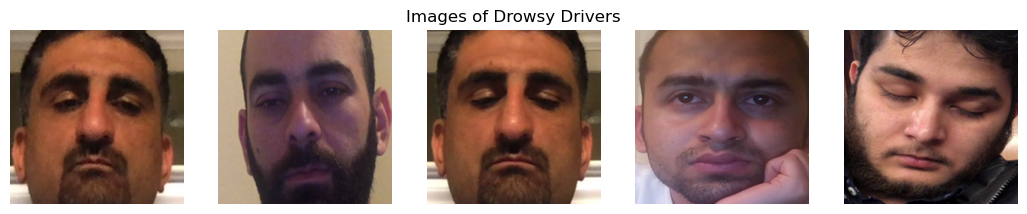

In [5]:
# Drowsy Images
train_path = '/kaggle/input/splitted-ddd/output/train'
drowsy_files = os.listdir('/kaggle/input/splitted-ddd/output/train/Drowsy')
plt.figure(figsize=(13, 6))

for i in range(5):
    img = Image.open(train_path +'/Drowsy/' + drowsy_files[np.random.randint(0, len(drowsy_files))])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    if i == 2:
        plt.title('Images of Drowsy Drivers')


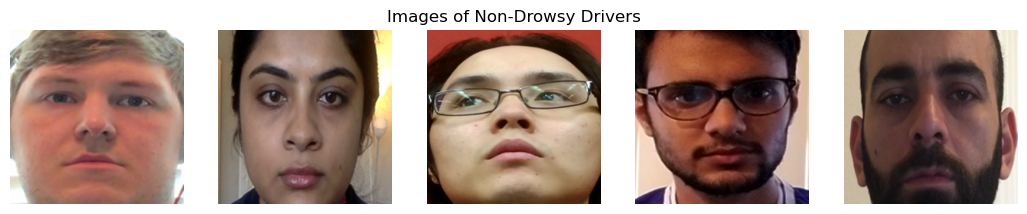

In [6]:
nondrowsy_files = os.listdir('/kaggle/input/splitted-ddd/output/train/Non Drowsy')
plt.figure(figsize=(13, 6))

for i in range(5):
    img = Image.open(train_path +'/Non Drowsy/' + nondrowsy_files[np.random.randint(0, len(nondrowsy_files))])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    if i == 2:
        plt.title('Images of Non-Drowsy Drivers')

In [7]:
# define data augmentation transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Create the dataset from train images
dataset = ImageFolder(train_path, transform=train_transforms)

In [8]:
# Dividing the dataset into train and test dataset
train_size = np.int32(0.8 * len(dataset)) # Number of images in train dataset
test_size = len(dataset) - train_size # Number of images in test dataset

# Splitting the dataset randomly
train_data, test_data = random_split(dataset, [train_size, test_size])

# Constructing the loaders with batch size 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


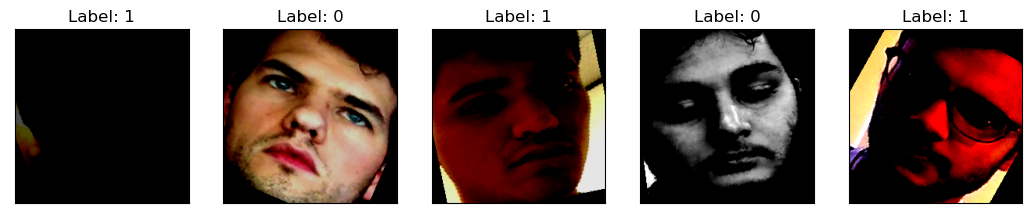

In [9]:
images, labels = next(iter(train_loader))

# Display the images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(13, 6))
for i in range(5):
    axes[i].imshow(images[i].numpy().transpose((1, 2, 0)))
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

In [10]:
# Loading Data for prediction
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

dataset = ImageFolder('/kaggle/input/splitted-ddd/output/val', transform=train_transforms)

In [11]:
test_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

In [12]:
criterion = nn.BCELoss()

In [13]:
# DDN
import sys
sys.path.append("/kaggle/input/net-and-helper-functions")
from net import Net

In [14]:
st = time.time()
DDN = Net().to(device)
DDN.load_state_dict(torch.load('/kaggle/input/training-net-on-entire-face/net.pth'))
DDN.eval()

with torch.no_grad():
    test_loss = 0.0
    test_auc = 0.0
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.squeeze(DDN(inputs))
        labels , outputs = labels.type(torch.FloatTensor),outputs.type(torch.FloatTensor)
        loss = criterion(outputs,labels)
        test_loss += loss.item()
        test_auc += binary_f1_score(outputs, labels)

print(f"The loss on testing data is {test_loss/len(test_loader)} and the F1 score is {test_auc/len(test_loader)}")
print("--- %s seconds ---" % (time.time() - st))

The loss on testing data is 0.007114223766372809 and the F1 score is 0.9966519474983215
--- 30.5557599067688 seconds ---


In [15]:
# VGG 16
class vgg (nn.Module):
    def __init__(self):
        super(vgg, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        self.vgg = torch.nn.Sequential(*list(self.vgg.children())[:-2])
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, 1))
        
    def forward (self, x):
        x = self.vgg(x)
        #print(x.shape)
        x = self.fc(self.flatten(x))
        x = self.fc1(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [16]:
st = time.time()
VGG = vgg().to(device)
VGG.load_state_dict(torch.load('/kaggle/input/training-vgg16-entire-face/vgg.pth'))
VGG.eval()

with torch.no_grad():
    test_loss = 0.0
    test_auc = 0.0
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.squeeze(VGG(inputs))
        labels , outputs = labels.type(torch.FloatTensor),outputs.type(torch.FloatTensor)
        loss = criterion(outputs,labels)
        test_loss += loss.item()
        test_auc += binary_f1_score(outputs, labels)

print(f"The loss on testing data is {test_loss/len(test_loader)} and the F1 score is {test_auc/len(test_loader)}")
print("--- %s seconds ---" % (time.time() - st))

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

The loss on testing data is 0.011655238009993671 and the F1 score is 0.9971052408218384
--- 36.38300180435181 seconds ---


In [17]:
# Resnet50
class resnet (nn.Module):
    def __init__(self):
        super(resnet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = torch.nn.Sequential(*list(self.resnet.children())[:-1])
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 1000),
            nn.ReLU())
        self.fc1= nn.Sequential(
            nn.Linear(1000, 1))
        
    def forward (self, x):
        x = self.resnet(x)
        #print(x.shape)
        x = self.fc(self.flatten(x))
        x = torch.sigmoid(self.fc1(x))
        return x

In [18]:
st = time.time()
resnet = resnet().to(device)
resnet.load_state_dict(torch.load('/kaggle/input/training-resnet-entire-face/resnet.pth'))
resnet.eval()

with torch.no_grad():
    test_loss = 0.0
    test_auc = 0.0
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.squeeze(resnet(inputs))
        labels , outputs = labels.type(torch.FloatTensor),outputs.type(torch.FloatTensor)
        loss = criterion(outputs,labels)
        test_loss += loss.item()
        test_auc += binary_f1_score(outputs, labels)

print(f"The loss on testing data is {test_loss/len(test_loader)} and the F1 score is {test_auc/len(test_loader)}")
print("--- %s seconds ---" % (time.time() - st))

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

The loss on testing data is 0.09182441646628307 and the F1 score is 0.9620469808578491
--- 23.99729609489441 seconds ---
